In [1]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [6]:
train_dir='/content/drive/MyDrive/casting_data/train'
test_dir='/content/drive/MyDrive/casting_data/test'

In [7]:
train_transforms = transforms.Compose([transforms.RandomRotation(50),  
                                       transforms.RandomResizedCrop(224),  
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.RandomAutocontrast(0.8),
                                       transforms.RandomSolarize(0.97),
                                       transforms.AutoAugment(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                        [0.229, 0.224, 0.225])
                                       ])


test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])
                                      ])

In [8]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

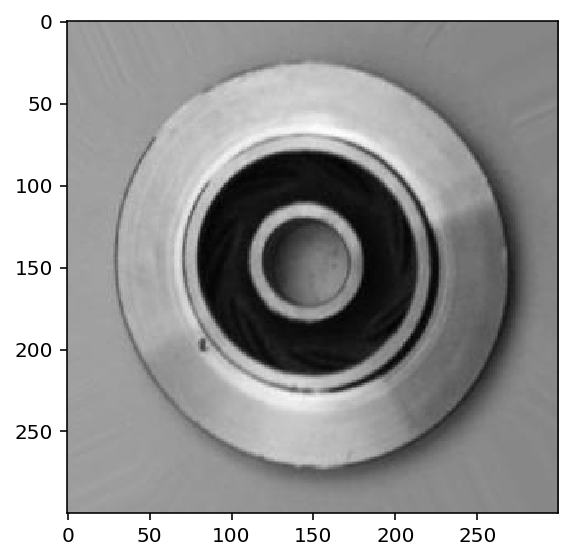

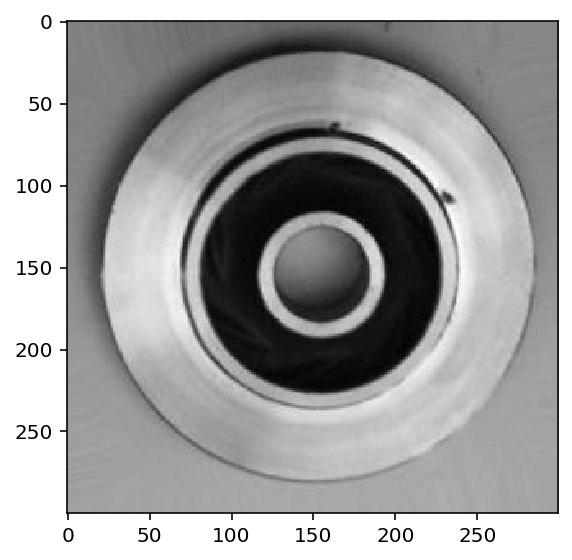

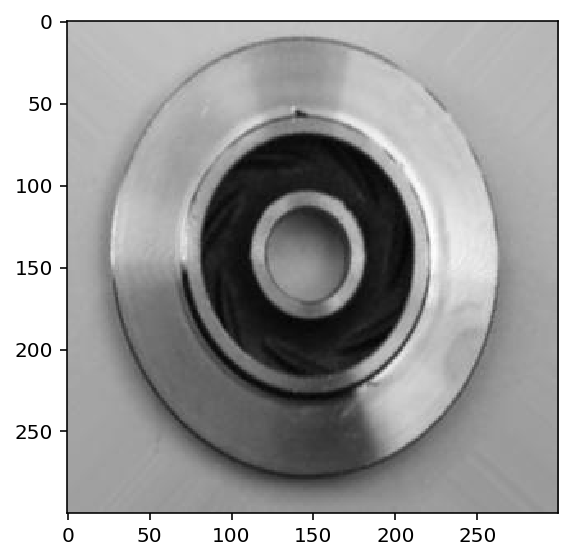

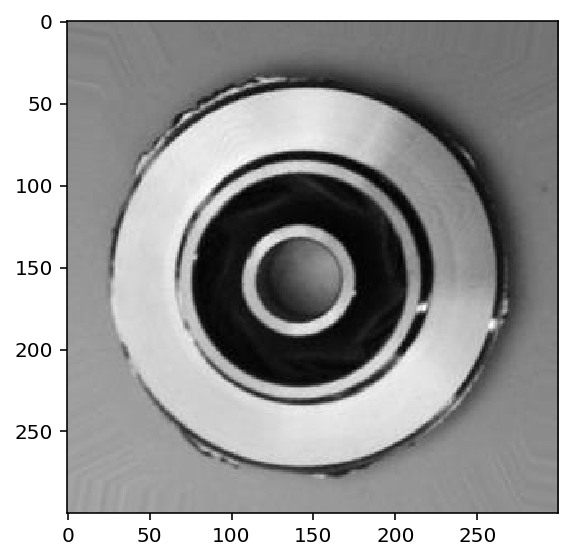

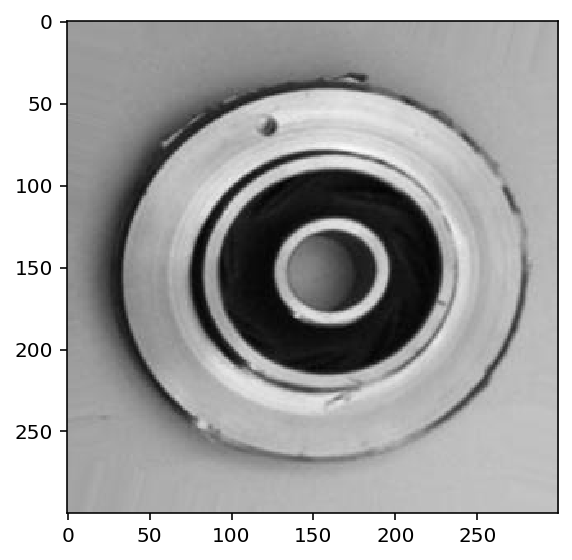

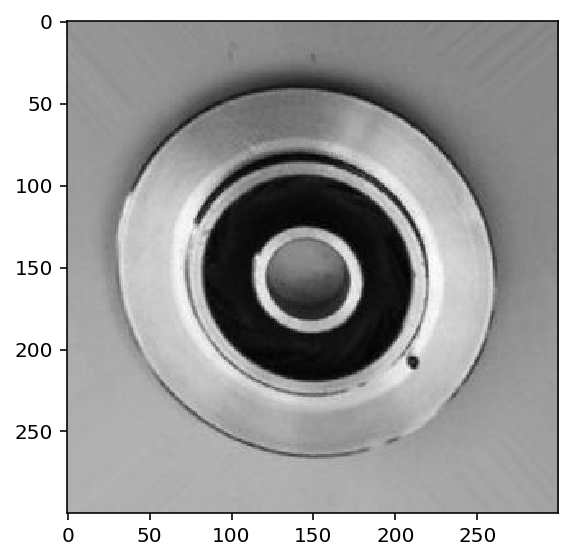

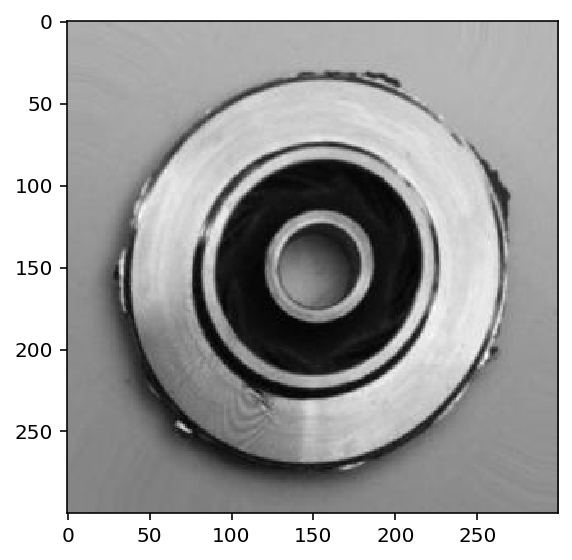

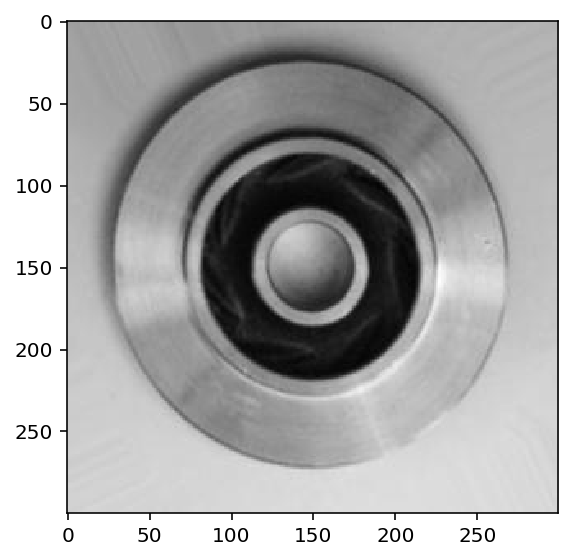

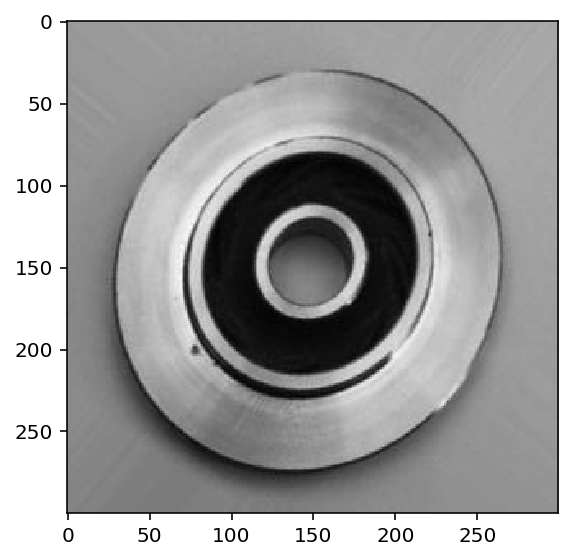

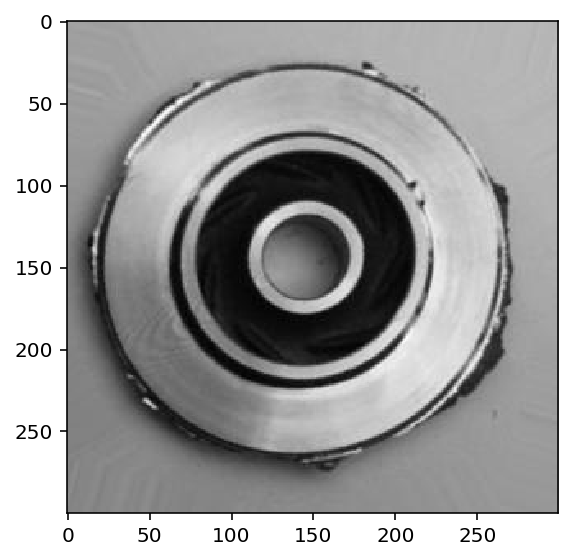

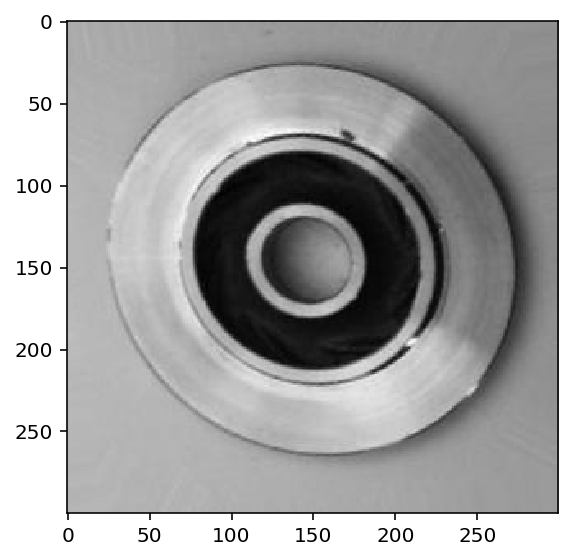

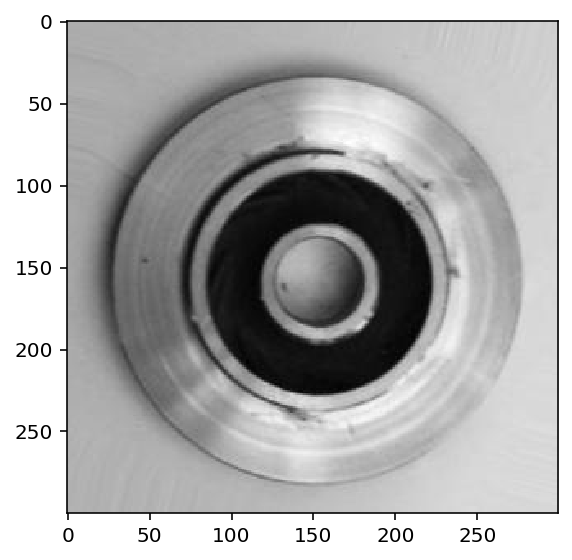

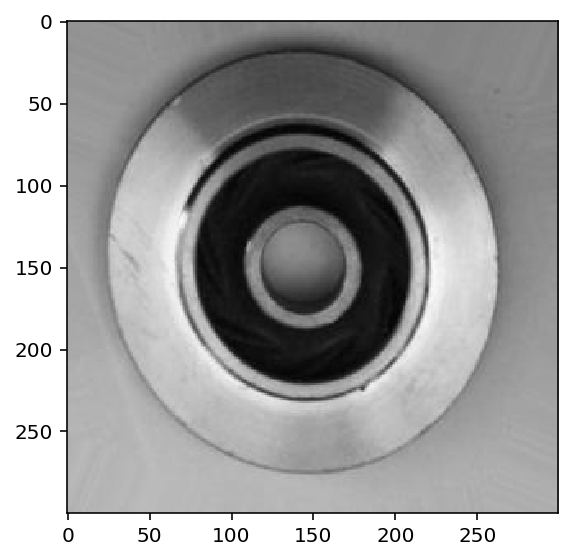

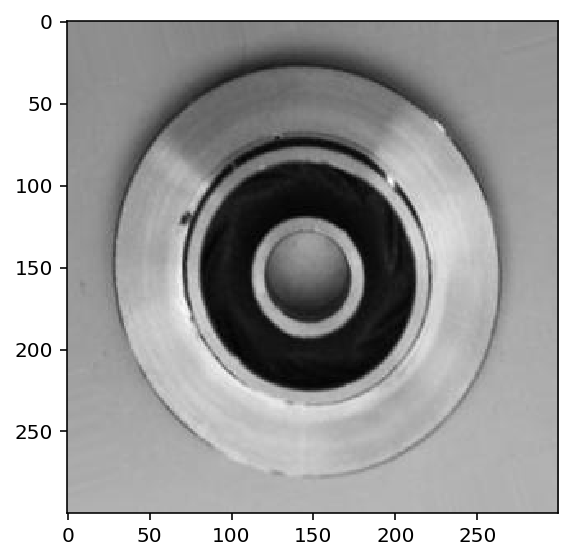

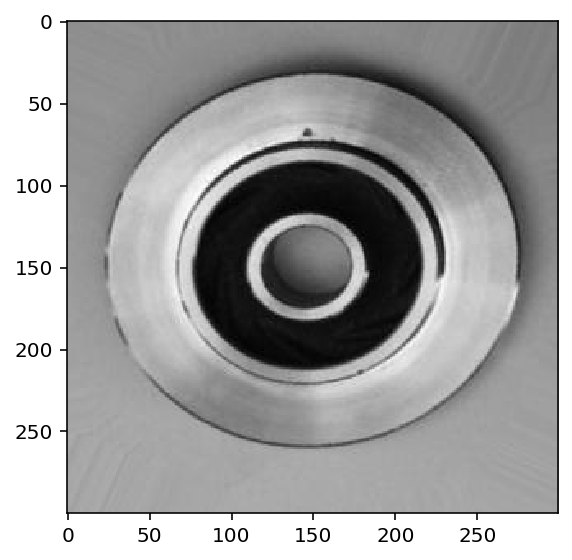

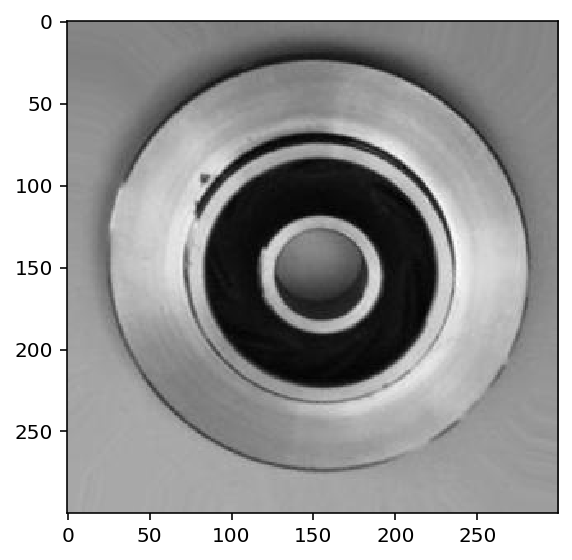

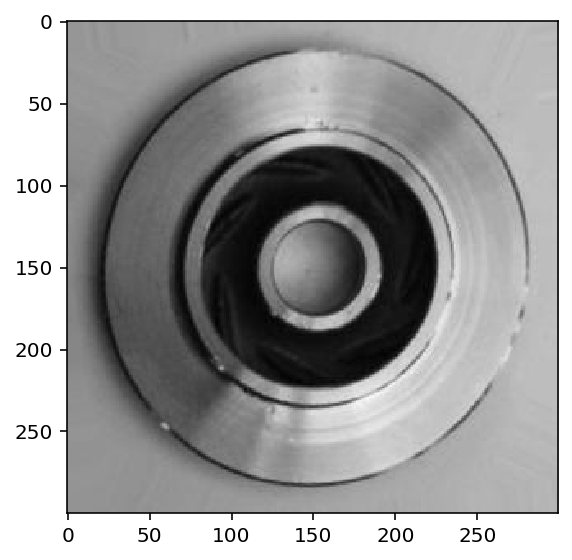

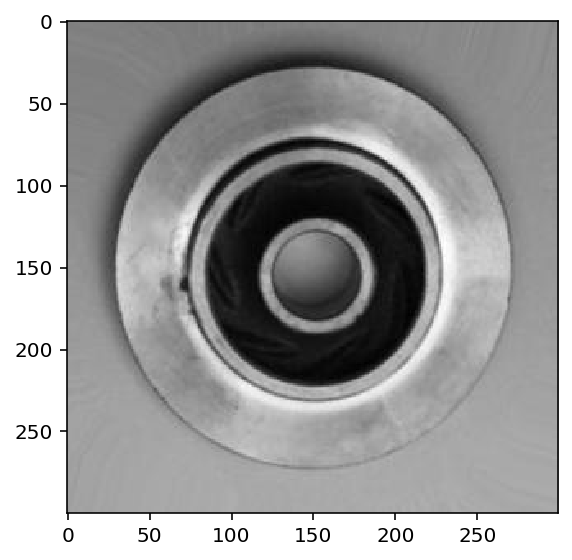

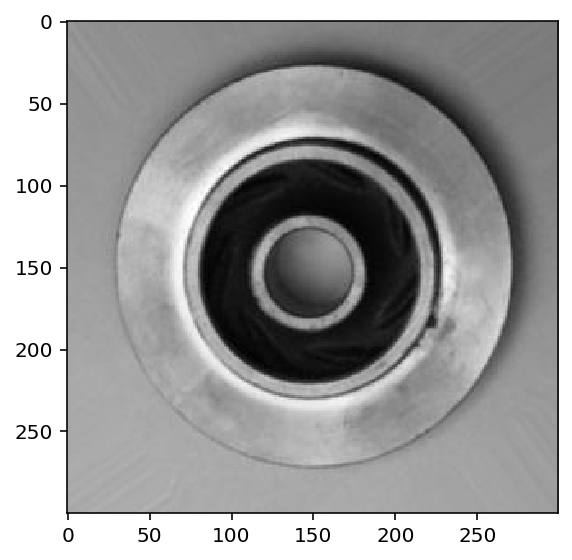

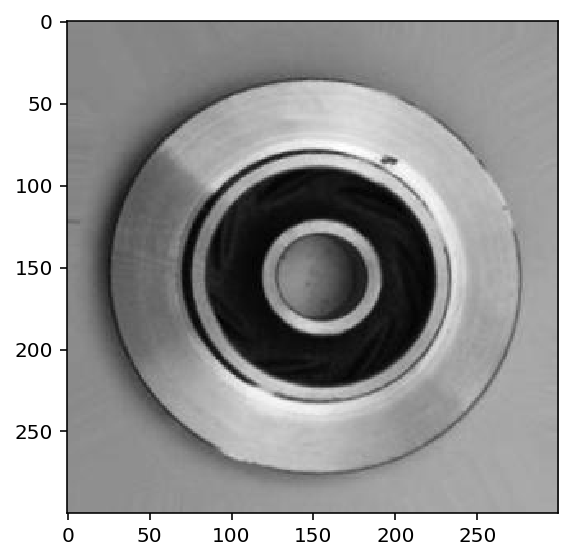

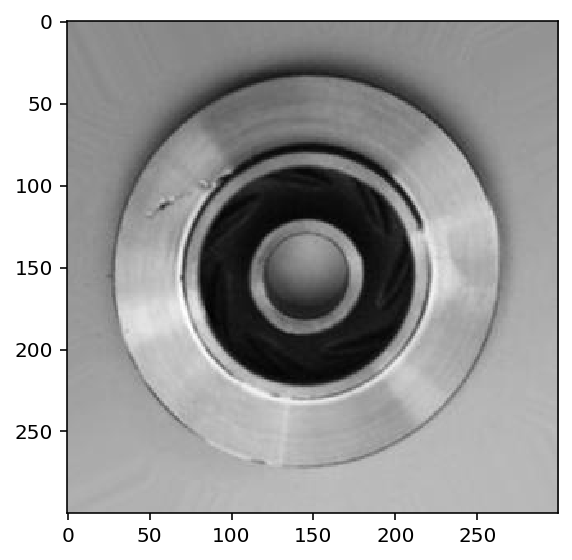

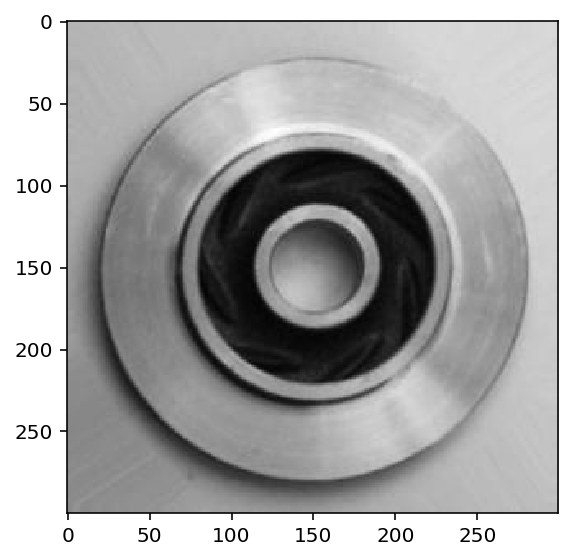

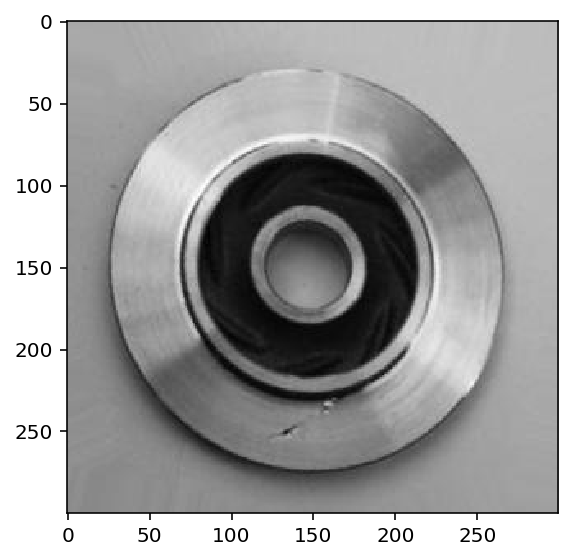

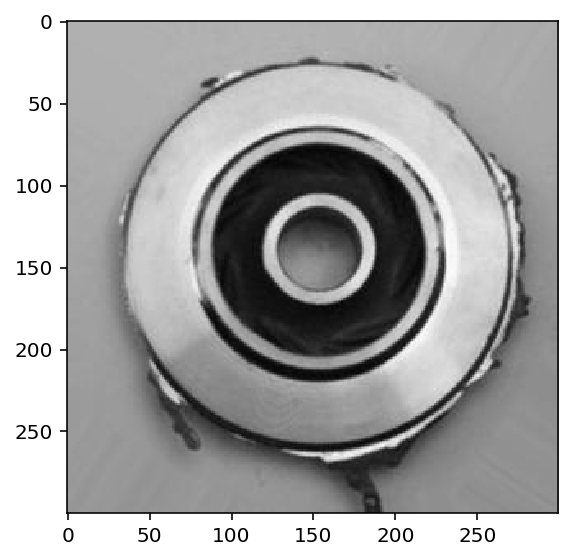

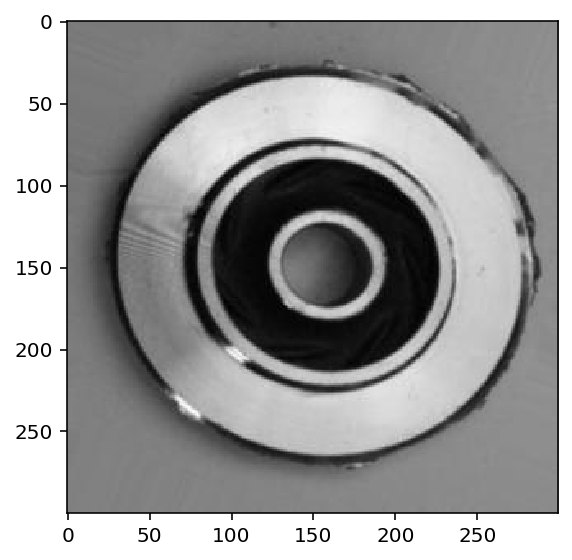

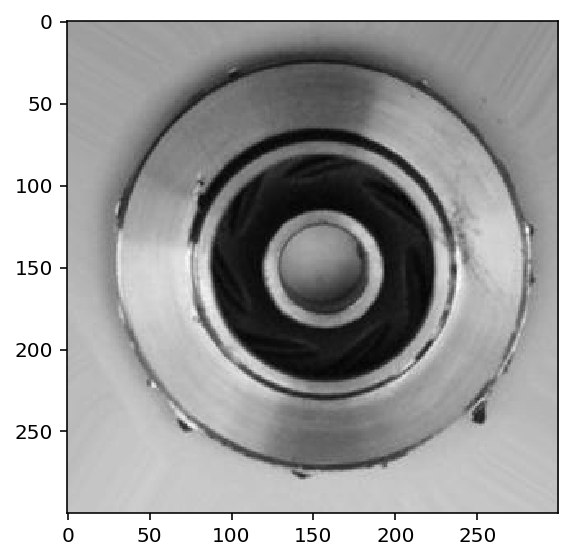

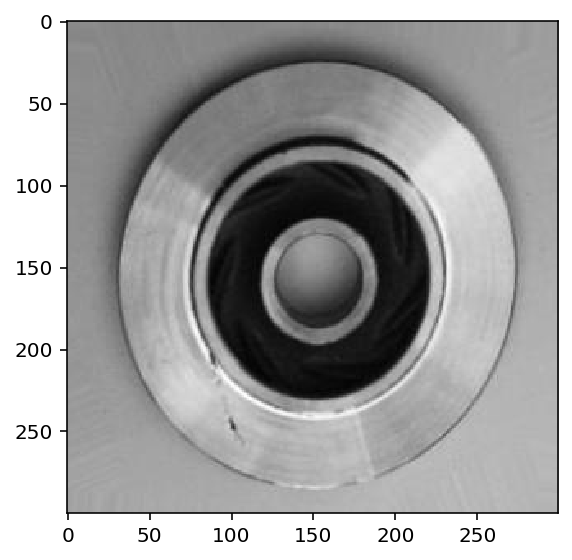

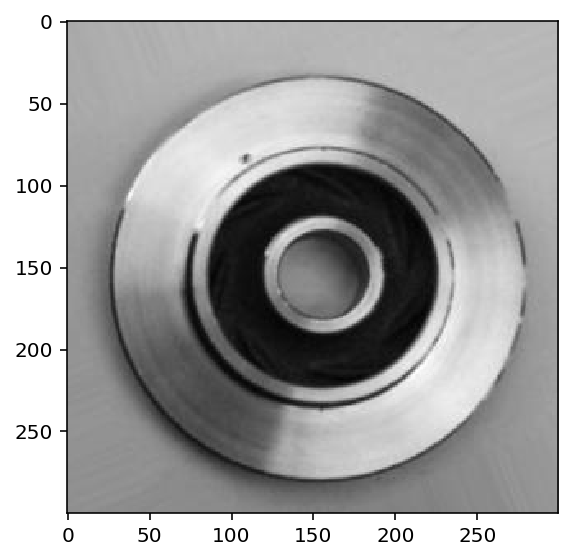

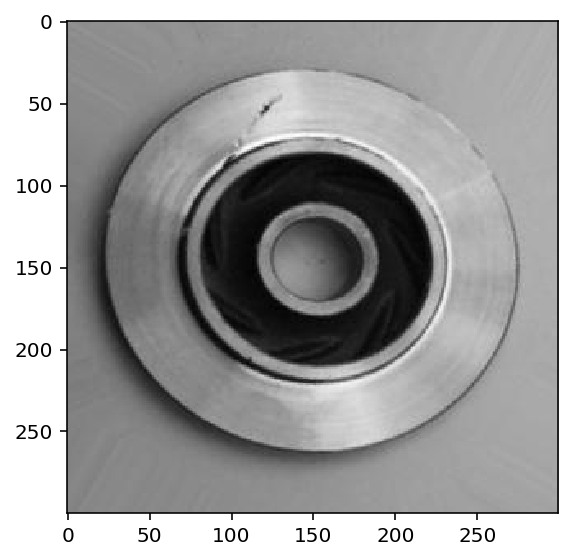

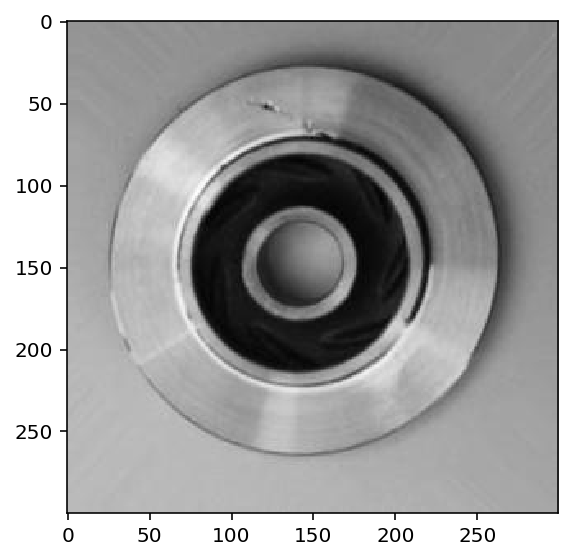

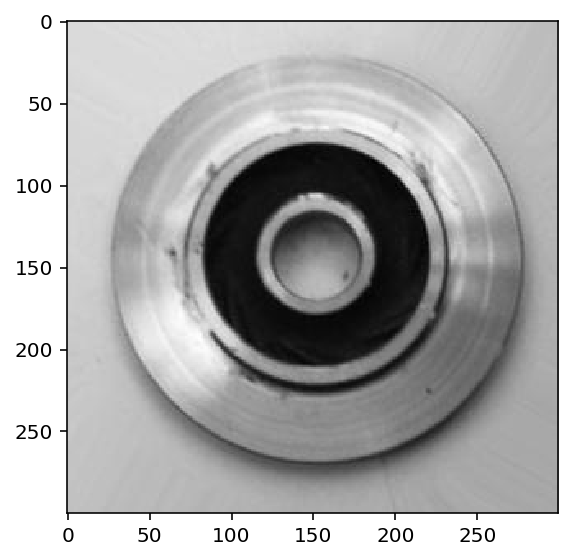

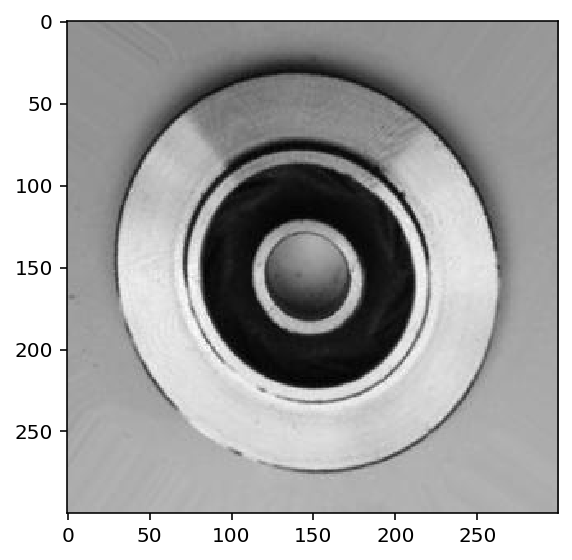

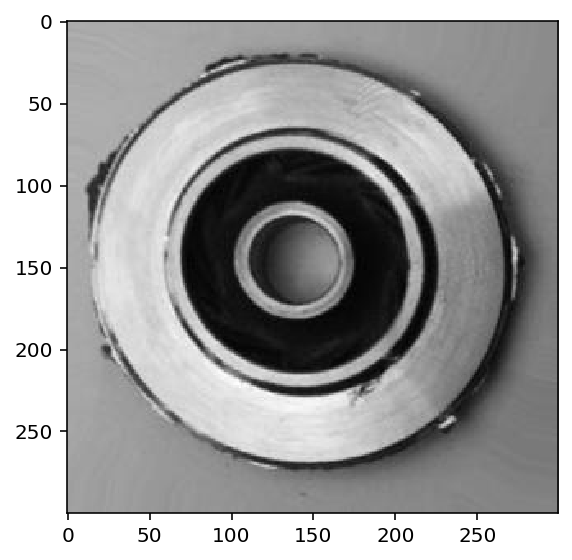

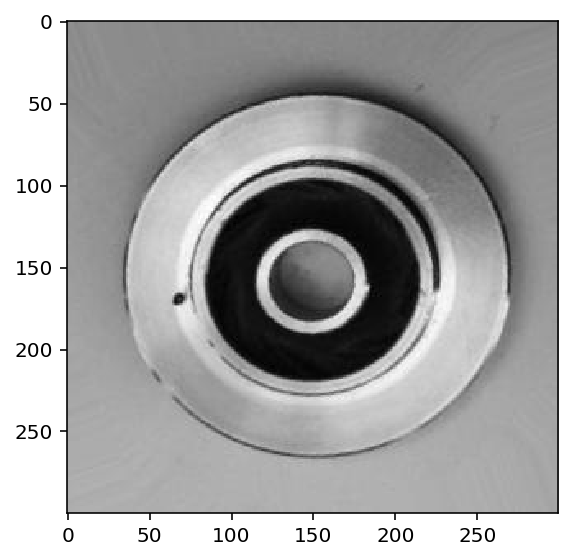

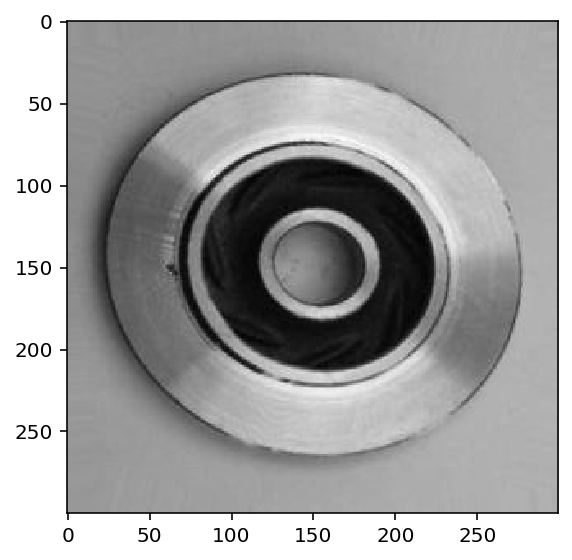

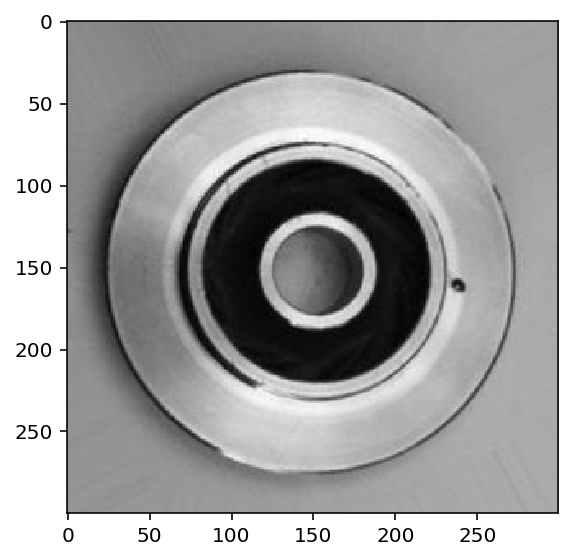

KeyboardInterrupt: ignored

In [5]:
from skimage import io
for item1,item2 in train_data.imgs:
    for i in range(0,5):
        io.imshow(item1)
        io.show()
        break

    

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [10]:
print(testloader.dataset.classes)

['def_front', 'ok_front']


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512, 2),
                        nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []


for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for data in testloader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            

Epoch 1/1.. Train loss: 0.068.. Test loss: 60.306.. Test accuracy: 0.590
Epoch 1/1.. Train loss: 0.000.. Test loss: 95.397.. Test accuracy: 0.590
Epoch 1/1.. Train loss: 0.000.. Test loss: 113.204.. Test accuracy: 0.590
Epoch 1/1.. Train loss: 0.000.. Test loss: 119.368.. Test accuracy: 0.590
Epoch 1/1.. Train loss: 0.000.. Test loss: 121.985.. Test accuracy: 0.590
Epoch 1/1.. Train loss: 28.098.. Test loss: 78.343.. Test accuracy: 0.590
Epoch 1/1.. Train loss: 33.987.. Test loss: 20.600.. Test accuracy: 0.410
Epoch 1/1.. Train loss: 0.000.. Test loss: 37.884.. Test accuracy: 0.410
Epoch 1/1.. Train loss: 0.000.. Test loss: 45.667.. Test accuracy: 0.410
Epoch 1/1.. Train loss: 0.000.. Test loss: 48.507.. Test accuracy: 0.410


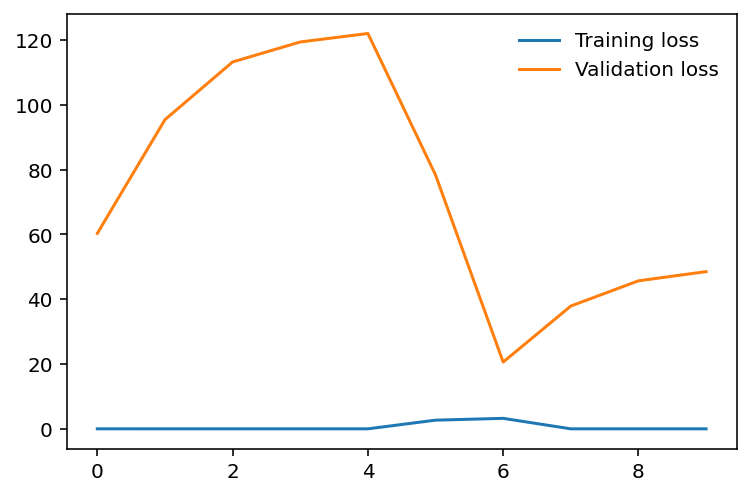

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [44]:
testloader.dataset

Dataset ImageFolder
    Number of datapoints: 715
    Root location: /content/drive/MyDrive/casting_data/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
model.eval()
model